In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from itertools import product
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from gensim.models import Word2Vec

In [2]:
def clean_text(text):

    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = set(stopwords.words('english'))
    stop = [w for w in stop if w not in ['not', 'no']]
    text = [x for x in text if (x not in stop)]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    # tokenize the text
    text = text.split()
    return(text)
def apply_cleaning(X_train):
    
    X_train = X_train.apply(lambda x: clean_text(x))
    return(X_train)

def tfidf_featured_data(X_train):


    X_train = apply_cleaning(X_train)
    # add tf-idfs columns
    tfidf = TfidfVectorizer(min_df = 30)
    tfidf_result = tfidf.fit_transform(X_train).toarray()
    tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
    tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
    tfidf_df.index = X_train.index
    X_train = pd.concat([X_train, tfidf_df], axis=1)
    X_train.drop(columns = ['sentences'], inplace = True)
    
    return X_train

def dict2text(dicti):
    '''
    This function is used to convert the dictionary of parameters to a string
    used for GridsearchCV outputs to be saved in a csv file and to be used later 
    on project.
    '''
    text = ''
    for key, value in dicti.items():
        text += str(key) + '=' + str(value) + ' '
    return text

def format_params(params_str):

    # Remove the opening and closing braces and quotes
    params_str = params_str.replace("{", "").replace("}", "").replace("'", "")

    # Replace commas with spaces
    params_str = params_str.replace(", ", " ")

    # Replace colons with equals signs
    params_str = params_str.replace(":", "=")

    # Remove spaces around equals signs
    params_str = params_str.replace("= ", "=").replace(" =", "=")

    return params_str

def evaluate_roc(probs, y_true):

    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def roc_auc(test, y_pred):
    # Assuming y_true contains the true labels (0 or 1) and y_pred contains the predicted probabilities for the positive class
    fpr, tpr, thresholds = roc_curve(test.values, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

def review_to_vector(review, word_embedding_model):
    vectors = []
    for word in review:
        if word in word_embedding_model.wv:
            vectors.append(word_embedding_model.wv[word])
    
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word_embedding_model.vector_size)

In [3]:
train = pd.read_csv("train.csv")
train["text"] = apply_cleaning(train["text"])

In [4]:
#create the word embeddings
text = train["text"].values  # List of sentences or list of word lists
model = Word2Vec(text, vector_size=100, window=5, min_count=1)

In [5]:
model.wv.similar_by_word("good")

[('still', 0.9997761249542236),
 ('that’s', 0.9997276067733765),
 ('helps', 0.9997183084487915),
 ('moisturizing', 0.9997135996818542),
 ('no', 0.9997076392173767),
 ('however', 0.99970543384552),
 ('something', 0.9997016191482544),
 ('stuff', 0.9996960163116455),
 ('better', 0.9996911287307739),
 ('find', 0.9996908903121948)]

In [6]:
model.wv.similar_by_word("bad")

[('that’s', 0.9996840953826904),
 ('can’t', 0.9996655583381653),
 ('get', 0.9996496438980103),
 ('actually', 0.9996437430381775),
 ('find', 0.999640166759491),
 ('packaging', 0.9996390342712402),
 ('ingredients', 0.9996358156204224),
 ('pretty', 0.9996341466903687),
 ('something', 0.9996306300163269),
 ('new', 0.9996291399002075)]

In [7]:
from sklearn.svm import SVC


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train["text"], train["sentiment"], test_size=0.99, random_state=40)

text = X_train.values
X_train = X_train
y_train = y_train
X_val = X_val
y_val = y_val

# Define the hyperparameters to tune
embedding_sizes = [300]
window_sizes = [3, 7]
min_count_values = [1, 5]
svm_C_values = [0.1, 1, 10]

best_score = 0
best_embedding_size = None
best_window_size = None
best_min_count = None
best_svm_params = {}

# Loop over different hyperparameter combinations for Word2Vec
for embedding_size in embedding_sizes:
    for window_size in window_sizes:
        for min_count in min_count_values:
            print(f'Embedding size: {embedding_size} / Window size: {window_size} / Min count: {min_count}')
            
            # Train the Word2Vec model
            model = Word2Vec(text, vector_size=embedding_size, window=window_size, min_count=min_count)

            X_train_vectors = np.array([review_to_vector(review, model) for review in X_train])
            X_val_vectors = np.array([review_to_vector(review, model) for review in X_val])
            
            # Perform hyperparameter tuning for SVM
            for C in svm_C_values:
                print(f'SVM regularization parameter: {C}')
                svm = SVC(C=C, kernel='rbf')
                svm.fit(X_train_vectors, y_train)
                val_score = accuracy_score(y_val, svm.predict(X_val_vectors))
                print(f'Validation score: {val_score}')
                if val_score > best_score:
                        best_score = val_score
                        best_embedding_size = embedding_size
                        best_window_size = window_size
                        best_min_count = min_count
                        best_svm_params['C'] = C

print("Best embedding size:", best_embedding_size)
print("Best window size:", best_window_size)
print("Best min count:", best_min_count)
print("Best SVM parameters:", best_svm_params)
print("Best score:", best_score)

Embedding size: 300 / Window size: 3 / Min count: 1
SVM regularization parameter: 0.1
Validation score: 0.6558823529411765
SVM regularization parameter: 1
Validation score: 0.6558823529411765
SVM regularization parameter: 10
Validation score: 0.5672268907563025
Embedding size: 300 / Window size: 3 / Min count: 5
SVM regularization parameter: 0.1
Validation score: 0.6558823529411765
SVM regularization parameter: 1
Validation score: 0.6134453781512605
SVM regularization parameter: 10
Validation score: 0.534453781512605
Embedding size: 300 / Window size: 7 / Min count: 1
SVM regularization parameter: 0.1
Validation score: 0.6558823529411765
SVM regularization parameter: 1
Validation score: 0.6558823529411765
SVM regularization parameter: 10
Validation score: 0.561344537815126
Embedding size: 300 / Window size: 7 / Min count: 5
SVM regularization parameter: 0.1
Validation score: 0.6558823529411765
SVM regularization parameter: 1
Validation score: 0.6134453781512605
SVM regularization param

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       117
           1       0.57      0.08      0.14       302
           2       0.67      0.99      0.80       784

    accuracy                           0.67      1203
   macro avg       0.41      0.36      0.31      1203
weighted avg       0.58      0.67      0.56      1203



C:\Users\khoxh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\khoxh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\khoxh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


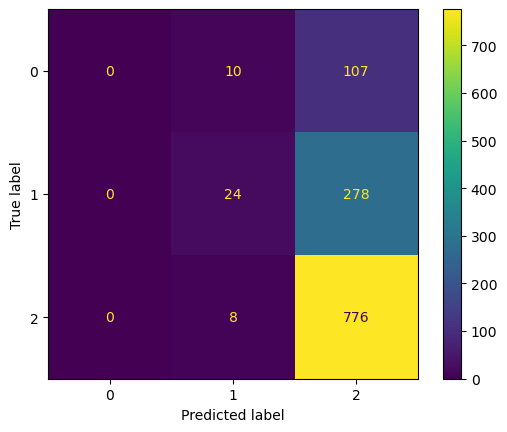

In [8]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

# Function to convert text to word embeddings
def text_to_word_embeddings(text, model):
    embeddings = []
    for sentence in text:
        # Ensure each sentence is a string
        if isinstance(sentence, str):
            words = sentence.split()
            vectors = []
            for word in words:
                if word in model.wv:
                    vectors.append(model.wv[word])
            if vectors:
                embeddings.append(np.mean(vectors, axis=0))
            else:
                embeddings.append(np.zeros(model.vector_size))
        else:
            # Handle empty sentences by adding a zero vector
            embeddings.append(np.zeros(model.vector_size))
    return np.array(embeddings)


train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
text = [text.split() for text in train["text"]]

# Train Word2Vec model
model = Word2Vec(text, vector_size=300, window=5, min_count=1, workers=4)

# Save the trained Word2Vec model
model.save("word2vec_model.bin")

# Convert text to word embeddings
X_train = text_to_word_embeddings(train["text"], model)
X_test = text_to_word_embeddings(test["text"], model)

# Train the SVM model
svm = LinearSVC()
svm.fit(X_train, train["sentiment"])

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Define y_test based on test data
y_test = test["sentiment"]

# Evaluate the model
def evaluation_parametrics(name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    t1 = ConfusionMatrixDisplay(cm)
    print("Classification Report")
    print(classification_report(y_test, y_pred))
    t1.plot()

evaluation_parametrics("Machine Learning Classification", y_test, y_pred)


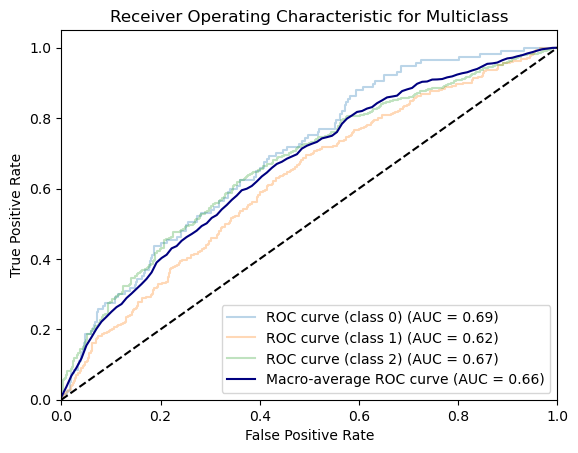

In [15]:
from sklearn.preprocessing import label_binarize
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from gensim.models import Word2Vec
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

train = pd.read_csv("train.csv")
train["text"] = apply_cleaning(train["text"])
text = train["text"].values
X_train = train["text"]
test = pd.read_csv("test.csv")
test["text"] = apply_cleaning(test["text"])
X_test = test["text"]
y_test = test['sentiment']
y_train = train["sentiment"]

n_classes = len(np.unique(y_test))

# Train the Word2Vec model
model = Word2Vec(text, vector_size=300, window=7, min_count=5)

X_train_vectors = np.array([review_to_vector(review, model) for review in X_train])
X_test_vectors = np.array([review_to_vector(review, model) for review in X_test])

# Train the SVM model
svm = LinearSVC(C=1, penalty='l2', loss="squared_hinge")
svm.fit(X_train_vectors, y_train)

# Evaluate the model
y_pred = svm.predict(X_test_vectors)
y_pred_probs = svm.decision_function(X_test_vectors)  # Prediction probabilities

def evaluate_roc_probs(probs, y_true, average='micro'):
    # Binarize the labels
    y_true_binarized = label_binarize(y_true, classes=np.unique(y_true))

    # Compute ROC curve and ROC area
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro/macro-averaged ROC curve and ROC area
    if average == 'micro':
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        fpr_macro = all_fpr
        tpr_macro = mean_tpr
        roc_auc_macro = auc(fpr_macro, tpr_macro)

        plt.plot(fpr_macro, tpr_macro, label='Micro-average ROC curve (AUC = {:.2f})'.format(roc_auc_macro))

    elif average == 'macro':
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (AUC = {:.2f})'.format(i, roc_auc[i]), alpha=0.3)

        # Compute macro-average ROC curve and ROC area
        fpr_macro = np.linspace(0, 1, 100)
        tpr_macro = np.zeros_like(fpr_macro)
        for i in range(n_classes):
            tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
        tpr_macro /= n_classes
        roc_auc_macro = auc(fpr_macro, tpr_macro)

        plt.plot(fpr_macro, tpr_macro, label='Macro-average ROC curve (AUC = {:.2f})'.format(roc_auc_macro), color='navy')

    else:
        raise ValueError("Invalid value for 'average'. Use 'micro' or 'macro'.")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multiclass')
    plt.legend(loc="lower right")
    plt.show()

evaluate_roc_probs(y_pred_probs, test["sentiment"].values, average='macro')


In [16]:
pd.DataFrame(y_pred).to_csv("y_pred_embeddings.csv")

<AxesSubplot:xlabel='sentiment'>

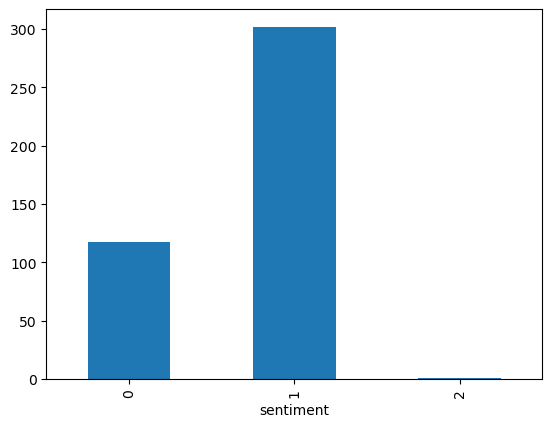

In [17]:
test = pd.read_csv(("test.csv"))
test["y_pred"] = y_pred
test[test["sentiment"] != test["y_pred"]].groupby('sentiment').count()["text"].plot(kind="bar")

In [21]:
pd.set_option('display.max_colwidth', None)
test[test["sentiment"] == test["y_pred"]].sample(5)

,text,sentiment,y_pred
164,"I received my #freeproduct sample of Clinique’s Smart Clinical Repair Wrinkle Correcting Cream though #topboxcircle. This moisturizer goes a long way, especially when coupled with the eye cream and serum! This product was lightweight and leaves my skin feeling soft and moisturized throughout the day. I haven’t used Clinique products since I was a young adult, but I would definitely add this line back to my regime.",2,2
887,I fell in love with this product when I saw it. I love their packaging. This one is in the shape of a plum. This serum is perfect for my skin. The consistency is very lightweight and absorbs fast. I love glow recipe all their products are awesome. I give this five stars. I received this complimentary for testing purposes.,2,2
922,It Works great for me. I loved this item and it worked so well for me. I would recommend this to anyone looking for fun extra steps or things to add to their skincare routine. It came quickly and worked great!,2,2
506,I could feel the hydration instantly when I put this on my face. I have oily skin and this absorbed very quickly and didn’t leave me feeling sticky. Very impressed and it smells great too!,2,2
1114,I’ve been using this product for about 3 days before going to bed and I’ve noticed a HUGE difference. My lips don’t feel as dry anymore throughout the day and they feel so soft!! I also noticed a reduction in the fine lines on my lips. Highly recommend this product!!,2,2


In [22]:
pd.set_option('display.max_colwidth', None)
test[test["sentiment"] != test["y_pred"]].sample(5)

,text,sentiment,y_pred
956,"My cousin uses this product she says it work for her, but personally it ruined my skin. Ended up covered in acne. YTTP may be too vegan for me….",0,2
671,I love this product. Great yet gentle exfoliation.,1,2
402,I so wanted this to work since I’m sick of trying different eye creams lately and there was a lot of great reviews. My eye area is sensitive and getting dry as we head into winter. After a week the area started to tingle when i applied it and then after 10 days it started to flake and was worse with makeup. I don’t mind spending money on a product if it’s beneficial and works but sadly this did not. I returned it. For me tatcha products are hit or miss. This was a miss.,0,2
784,I’ve heard many great things about this product but for me personally it didn’t work. It made my skin breakout.,0,2
115,Just an over expensive face wash. Does not remove ANY waterproof makeup and seriously irritated my skin (which I sensitive so this wasn’t very shocking). Considering it couldn’t even remove my B.B. cream I’m not sure if it’ll even wash the daily dirt and oils from your skin very well. Smells nice though,0,2
